In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from neuroCombat import neuroCombat
from scipy.stats import pearsonr

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 3.)

load data

In [149]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path+'hcp_data.npy')
n_subs = brain_networks.shape[0]

In [150]:
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [151]:
with open(data_path+'hcp_traits_dict.txt') as f:
    lines = f.readlines()
f.close()

In [152]:
pic_vocab = traits[:,6]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]
list_sort = traits[:,35]
fluid_intel = traits[:,2]

In [153]:
drop_ids = (np.isnan(pic_seq) | np.isnan(fluid_intel))
pic_vocab = pic_vocab[~drop_ids]
pattern_complete = pattern_complete[~drop_ids]
list_sort = list_sort[~drop_ids]
pic_seq = pic_seq[~drop_ids]
fluid_intel = fluid_intel[~drop_ids]

brain_networks = brain_networks[~drop_ids]
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [154]:
sub_ids = np.arange(n_subs).reshape(-1,1)
big_motion_ids = sub_ids[motion[:,1] > np.quantile(motion[:,1], .9)]
motion_group = np.zeros(n_subs)
motion_group[big_motion_ids] = 1

lr + pca

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])

y_obs = fluid_intel
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(brain_networks)
    reduced_data = pca.fit_transform(brain_networks)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_pred, y_obs[test_index])[0]

print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print(list(cv_corr))

In [3]:
lr_pic_vocab_corr = [0.20036643696274586, 0.24407839142986537, 0.3306855731943531, 0.24838339169290172, 0.18470133948498907]
lr_pattern_complete_corr = [0.06147570627480804, 0.10920220512272061, 0.08594747565888534, 0.01051167135126507, 0.08799807276004133]
lr_pic_seq_corr = [0.1325595457419895, 0.04501422114563117, 0.13455070264520402, 0.07436113557879709, 0.051445954645564576]
lr_list_sort_corr = [0.08572396888471592, 0.052875292483543515, 0.012409051633726461, 0.10770830701793149, 0.06285116867540659]
lr_fluid_intel_corr = [0.1450156659853011, 0.104728512890679, 0.07035683277408383, 0.11656204079992283, 0.09657994810243418]

sog

In [158]:
# save data for running SOG in R
# np.save('./saved_results/hcp_brain_networks.npy', brain_networks)
# np.save('./saved_results/hcp_motion.npy', motion_group)
# np.save('./saved_results/hcp_traits.npy', 
#         np.c_[pic_vocab, pattern_complete, pic_seq, list_sort, fluid_intel])

In [4]:
# load results from SOG with K = 68
sog_pic_vocab_corr = [0.2287315, 0.2786808, 0.1385156, 0.2875420, 0.3323576]
sog_pattern_complete_corr = [0.04114842, 0.12725077, 0.01537598, 0.08936695, 0.02324655]
sog_pic_seq_corr = [0.006822813, 0.006712983, 0.062736538, 0.107035647, 0.108812276]
sog_list_sort_corr = [0.13598796, 0.12739883, 0.04753566, 0.06709880, 0.09329560]
sog_fluid_intel_corr = [0.11836461, 0.02705343, 0.24208862, 0.19518919, 0.09025316]

combat

In [ ]:
covars = {'motion': motion_group} 
covars = pd.DataFrame(covars)  
adjusted_data = neuroCombat(
    dat=np.vstack(brain_networks).transpose(),
    covars=covars,
    batch_col='motion')["data"].transpose()
print(adjusted_data.shape)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])

y_obs = fluid_intel
for i, (train_index, test_index) in enumerate(kf.split(adjusted_data)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(adjusted_data)
    reduced_data = pca.fit_transform(adjusted_data)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_pred, y_obs[test_index])[0]

print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print(list(cv_corr))

In [5]:
combat_pic_vocab_corr = [0.16721217526771295, 0.2169635380838445, 0.2975547894278274, 0.24930450238776417, 0.1613443535660457]
combat_pattern_complete_corr = [0.06243471462822863, 0.11418300319983797, 0.09251996608372846, 0.003106884924198896, 0.08211540077266065]
combat_pic_seq_corr = [0.14635962456193857, 0.04485304287383043, 0.13432596169052033, 0.09188920533745336, 0.035652228506550636]
combat_list_sort_corr = [0.08572396888471592, 0.052875292483543515, 0.012409051633726461, 0.10770830701793149, 0.06285116867540659]
combat_fluid_intel_corr = [0.14805190032222987, 0.10743982979282075, 0.054983316467828156, 0.11177441700814758, 0.07682480753479201]

vae

In [ ]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=256, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .5, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=100, lr=2e-5, device=DEVICE)

In [ ]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [ ]:
y_obs = fluid_intel
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_rmses = np.zeros([5])

for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running GATE on fold {i+1} ...')
    vae = VAE(config).to(config.device)
    vae.apply(reset_weights)
    vae.set_mask(knn_masks)
    optimizer = optim.Adam(vae.parameters(), lr=config.lr) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = vae.reg_train(epoch, train_loader, vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy())[0]
    print("test corr: {:.2f}".format(cv_corr[i]))

print("avg 5-fold cv corr: {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print(list(cv_corr))

In [17]:
vae_pic_vocab_corr = [0.24044588693105443, 0.26728058115959297, 0.3662097255782459, 0.27125328313242025, 0.1502152014340511]
vae_pattern_complete_corr = [0.10258092727424958, 0.15625621123102613, 0.07805712631817811, 0.016248930826707655, 0.09902255949137649]
vae_pic_seq_corr = [0.09316911554229546, 0.186791347974489, 0.154196103119531, 0.0020197101101420913, 0.07784698000768397]
vae_list_sort_corr = [0.06803019288000356, 0.19020604729948848, 0.0665557677171187, 0.21569127915101838, 0.1713696605522442]
vae_fluid_intel_corr = [0.13292628162135767, 0.06206090053546001, 0.13715504578644902, 0.23732334211411285, 0.14288441913663705]

inv-vae

In [ ]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=256, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = 1.5, gamma = 1., add_reg = True, y_dim = 1,
    batch_size=64, n_epochs=100, lr=2e-5, device=DEVICE)

In [ ]:
y_obs = fluid_intel
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_rmses = np.zeros([5])

for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running inv-VAE on fold {i+1} ...')
    inv_vae = INV_VAE(config).to(config.device)
    inv_vae.apply(reset_weights)
    inv_vae.set_mask(knn_masks)
    optimizer = optim.Adam(inv_vae.parameters(), lr=config.lr) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = inv_vae.reg_train(epoch, train_loader, inv_vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = inv_vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                             tensor_motion[test_index].to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy())[0]
    print("test corr: {:.2f}".format(cv_corr[i]))

print("avg 5-fold cv corr: {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print(list(cv_corr))

In [7]:
inv_pic_vocab_corr = [0.269038231377544, 0.2738397771966285, 0.39958738740262323, 0.2962545178962678, 0.17578252878475648]
inv_pattern_complete_corr  = [0.09876664948482004, 0.15420591544270645, 0.08922044137885733, 0.05127235574157339, 0.06418885575942863]
inv_pic_seq_corr = [0.09767432552410896, 0.1798446495327203, 0.16909076863453557, 0.045275230971702635, 0.08470921818752171]
inv_list_sort_corr = [0.08335782709786495, 0.19110765896442264, 0.07249892907365094, 0.21384356009481809, 0.16868088522608932]
inv_fluid_intel_corr = [0.1398709936682626, 0.06400047453045553, 0.14064959964028895, 0.23249349715368353, 0.14840453313715646]

error-bar plots

In [18]:
lr_pca = np.c_[lr_pic_vocab_corr, lr_pattern_complete_corr, lr_pic_seq_corr, lr_list_sort_corr, lr_fluid_intel_corr]
combat = np.c_[combat_pic_vocab_corr, combat_pattern_complete_corr, combat_pic_seq_corr, combat_list_sort_corr, combat_fluid_intel_corr]
sog = np.c_[sog_pic_vocab_corr, sog_pattern_complete_corr, sog_pic_seq_corr, sog_list_sort_corr, sog_fluid_intel_corr]
vae = np.c_[vae_pic_vocab_corr, vae_pattern_complete_corr, vae_pic_seq_corr, vae_list_sort_corr, vae_fluid_intel_corr]
inv_vae = np.c_[inv_pic_vocab_corr, inv_pattern_complete_corr, inv_pic_seq_corr, inv_list_sort_corr, inv_fluid_intel_corr]

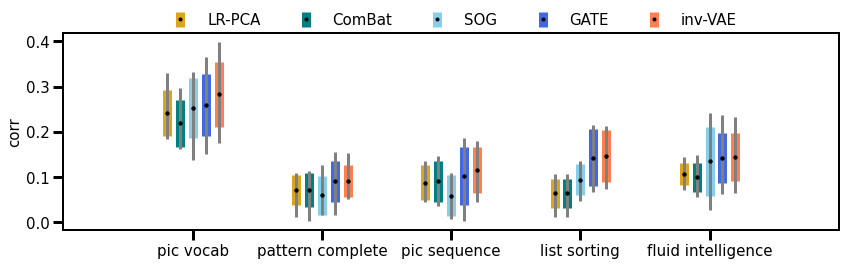

In [19]:
ticks = ['pic vocab', 'pattern complete', 'pic sequence', 'list sorting', 'fluid intelligence']

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

mins, maxs, means, stds = lr_pca.min(0), lr_pca.max(0), lr_pca.mean(0), lr_pca.std(0)
plt.errorbar(np.arange(len(ticks))*2-.4, means, stds, 
                 fmt='.k', ecolor='goldenrod', lw=9, label='LR-PCA')
plt.errorbar(np.arange(len(ticks))*2-.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = combat.min(0), combat.max(0), combat.mean(0), combat.std(0)
plt.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='.k', ecolor='teal', lw=9, label='ComBat')
plt.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = sog.min(0), sog.max(0), sog.mean(0), sog.std(0)
plt.errorbar(np.arange(len(ticks))*2, means, stds, 
                 fmt='.k', ecolor='skyblue', lw=9, label='SOG')
plt.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = vae.min(0), vae.max(0), vae.mean(0), vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.2, means, stds, 
             fmt='.k', ecolor='royalblue', lw=9, label='GATE')
plt.errorbar(np.arange(len(ticks))*2+.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = inv_vae.min(0), inv_vae.max(0), inv_vae.mean(0), inv_vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.4, means, stds, 
             fmt='.k', ecolor='coral', lw=9, label='inv-VAE')
plt.errorbar(np.arange(len(ticks))*2+.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=5, fancybox=False, shadow=False, frameon=False)

ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_xlim(-2, len(ticks)*2)
ax.set_ylabel('corr');

ax.tick_params(axis='both', length=10, width=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.tight_layout()
plt.savefig('saved_figs/inv_vae_fig7_hcp.png', facecolor='white', dpi=800)